# Adult black box creation

In this notebook I create and save two black boxes with similar performances over the data generated in the [`AdultDatasetPreparation.ipynb`](./AdultDatasetPreparation.ipynb) notebook:
* `adult_randfor.bz2` is a RandomForest with the following performances:
```
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      8157
           1       0.79      0.61      0.69      2690

    accuracy                           0.86     10847
   macro avg       0.84      0.78      0.80     10847
weighted avg       0.86      0.86      0.86     10847
```

    
* `adult_adab.bz2` is an Adaboost with the following performances:

```
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      8157
           1       0.78      0.64      0.70      2690

    accuracy                           0.87     10847
   macro avg       0.83      0.79      0.81     10847
weighted avg       0.86      0.87      0.86     10847
```


At the end of the notebook there are a few experiments with a NN which do not yield improvements over the above models.


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import sys
sys.path.append("../../")

sns.set_theme()

np.random.seed(123)

In [2]:
loaded = np.load("adult-blackbox-data.npz")
print(*loaded.keys())

X_train y_train X_test y_test X_validation y_validation X_validation_noisy y_validation_noisy X_attack_2_per_quantile y_attack_2_per_quantile X_attack_3_per_quantile y_attack_3_per_quantile categorical_features numerical_features categorical_features_mask centroids


In [3]:
X_train, y_train = loaded['X_train'], loaded['y_train']
X_test, y_test = loaded['X_test'], loaded['y_test']

# Creating a Black Box

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from utils.models import save_pickle_bz2

## Random Forest

In [5]:
# Hyperparameters of the grid search
__HYPERPARAMETERS = {
    "bootstrap": [True, False],
    "max_depth": [100, 350, 500],
    "min_samples_leaf": [10, 20, 50],
    "min_samples_split": [5, 10, 50],
    "n_estimators": [100, 150, 350, 500],
    "criterion": ["gini", "entropy"],
}

def create_random_forest(
        x,
        y,
        hyperparameters=__HYPERPARAMETERS,
        n_jobs=12
) -> RandomForestClassifier:
    """Creates a random forest classifier via grid search.

    Args:
        x (ndarray): Training input examples.
        y (ndarray): Training target values.
        hyperparameters (Dict[str, List[Any]], optional): Dictionary of hyperparameters for the grid search. Defaults to the fixed ones.
        n_jobs: Number of jobs to run in parallel in the grid search.

    Returns:
        RandomForestClassifier: Random forest classifier.
    """

    rf = RandomForestClassifier()
    clf = HalvingGridSearchCV(rf, hyperparameters, refit=True, n_jobs=n_jobs, verbose=0)
    clf.fit(x, y)
    return clf.best_estimator_

In [6]:
rf = create_random_forest(X_train, y_train)

In [7]:
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      8157
           1       0.79      0.61      0.69      2690

    accuracy                           0.86     10847
   macro avg       0.84      0.78      0.80     10847
weighted avg       0.86      0.86      0.86     10847



In [32]:
save_pickle_bz2("adult_randfor.bz2", rf)

## Adaboost

In [8]:
from sklearn.ensemble import AdaBoostClassifier

__HYPERPARAMETERS_AB = {
    "n_estimators": [50, 100, 150, 200],
    "random_state": [123]
}

def create_adaboost(
        x,
        y,
        hyperparameters=__HYPERPARAMETERS_AB,
        n_jobs=12
) -> RandomForestClassifier:
    """Creates a random forest classifier via grid search.

    Args:
        x (ndarray): Training input examples.
        y (ndarray): Training target values.
        hyperparameters (Dict[str, List[Any]], optional): Dictionary of hyperparameters for the grid search. Defaults to the fixed ones.
        n_jobs: Number of jobs to run in parallel in the grid search.

    Returns:
        RandomForestClassifier: Random forest classifier.
    """

    ab = AdaBoostClassifier()
    clf = HalvingGridSearchCV(ab, hyperparameters, refit=True, n_jobs=n_jobs, verbose=0)
    clf.fit(x, y)
    return clf.best_estimator_

In [9]:
ab = create_adaboost(X_train, y_train)

In [10]:
print(classification_report(y_test, ab.predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      8157
           1       0.78      0.64      0.70      2690

    accuracy                           0.87     10847
   macro avg       0.83      0.79      0.81     10847
weighted avg       0.86      0.87      0.86     10847



In [31]:
save_pickle_bz2("adult_adab.bz2", ab)

## Neural Network

In [12]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from scikeras.wrappers import KerasClassifier # this wrapper makes a keras model compatible with the sklearn APIs
tf.get_logger().setLevel('ERROR')
print(f"GPU?: {tf.config.list_physical_devices('GPU')}")

def create_neural_network(input_shape, activation="relu"):
    model = keras.Sequential([
        layers.Input(shape=(input_shape,)),
        layers.Dense(32, activation=activation),
        layers.Dense(16, activation=activation),
        layers.Dense(8, activation=activation),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

GPU?: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [13]:
model = create_neural_network(X_train.shape[1])

In [14]:
history = model.fit(X_train, y_train, epochs=20, validation_split=0.1, verbose=1)

Epoch 1/20
712/712 [==============================] - 2s 2ms/step - loss: 0.3930 - accuracy: 0.8233 - val_loss: 0.3435 - val_accuracy: 0.8356
Epoch 2/20
712/712 [==============================] - 1s 1ms/step - loss: 0.3305 - accuracy: 0.8445 - val_loss: 0.3417 - val_accuracy: 0.8376
Epoch 3/20
712/712 [==============================] - 1s 1ms/step - loss: 0.3266 - accuracy: 0.8470 - val_loss: 0.3384 - val_accuracy: 0.8333
Epoch 4/20
712/712 [==============================] - 1s 1ms/step - loss: 0.3248 - accuracy: 0.8479 - val_loss: 0.3341 - val_accuracy: 0.8408
Epoch 5/20
712/712 [==============================] - 1s 2ms/step - loss: 0.3228 - accuracy: 0.8488 - val_loss: 0.3422 - val_accuracy: 0.8368
Epoch 6/20
712/712 [==============================] - 1s 2ms/step - loss: 0.3219 - accuracy: 0.8487 - val_loss: 0.3371 - val_accuracy: 0.8356
Epoch 7/20
712/712 [==============================] - 1s 2ms/step - loss: 0.3202 - accuracy: 0.8504 - val_loss: 0.3345 - val_accuracy: 0.8404
Epoch 

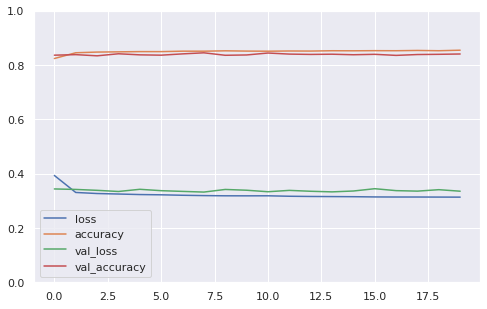

In [15]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [16]:
print(classification_report(y_test, model.predict(X_test).round()))

              precision    recall  f1-score   support

           0       0.87      0.94      0.91      8157
           1       0.76      0.59      0.67      2690

    accuracy                           0.85     10847
   macro avg       0.82      0.77      0.79     10847
weighted avg       0.85      0.85      0.85     10847

